# Práctica 4: Diagramas de Voronoi

Examina de manera sistemática el efecto del número de semillas y del tamaño de la zona en la distribución en las grietas que se forman en términos de si la grieta parte o no la pieza. 

### Experimento

El siguiente código está basado en el código implementado por la Dra. Elisa Schaeffer. El objetivo es, primeramente, determinar si la grieta parte o no la pieza. Como se considera una pieza de tamaño $n \times n$, se considera que sí la rompe cuando la grieta regresa a uno de los cuatro lados de la pieza. Es decir si su coordenada en $x$ coincide con 1 o con $n$, del mismo modo, si su coordenada en $y$ coincide con 1 o con $n$.

In [151]:
tamaño <-  c(50, 75, 100, 125, 150, 175, 200)
seed <-  c(2,4,6,8,10,20,30)
datos <- data.frame()

for (n in tamaño){
    for (m in seed){
        k=m*n
        zona <- matrix(rep(0, n * n), nrow = n, ncol = n)
        x <- rep(0, k) # ocupamos almacenar las coordenadas x de las semillas
        y <- rep(0, k) # igual como las coordenadas y de las semillas

        for (semilla in 1:k) {
            while (TRUE) { # hasta que hallamos una posicion vacia para la semilla
                fila <- sample(1:n, 1)
                columna <- sample(1:n, 1)
                if (zona[fila, columna] == 0) {
                    zona[fila, columna] = semilla
                    x[semilla] <- columna
                    y[semilla] <- fila
                    break
                }
            }
        }

        celda <-  function(pos) {
            fila <- floor((pos - 1) / n) + 1
            columna <- ((pos - 1) %% n) + 1
            if (zona[fila, columna] > 0) { # es una semilla
                return(zona[fila, columna])
            } else {
                cercano <- NULL # sin valor por el momento
                menor <- n * sqrt(2) # mayor posible para comenzar la busqueda
                for (semilla in 1:k) {
                    dx <- columna - x[semilla]
                    dy <- fila - y[semilla]
                    dist <- sqrt(dx^2 + dy^2)
                    if (dist < menor) {
                        cercano <- semilla
                        menor <- dist
                    }
                }
                return(cercano)
            }
        }

        suppressMessages(library(doParallel))
        registerDoParallel(makeCluster(detectCores() - 1))
        celdas <- foreach(p = 1:(n * n), .combine=c) %dopar% celda(p)
        stopImplicitCluster()
        voronoi <- matrix(celdas, nrow = n, ncol = n, byrow=TRUE)
        rotate <- function(x) t(apply(x, 2, rev))
        #png("p4s.png")
        #par(mar = c(0,0,0,0))
        #image(rotate(zona), col=rainbow(k+1), xaxt='n', yaxt='n')
        #graphics.off()
        #png("p4c.png")
        #par(mar = c(0,0,0,0))
        #image(rotate(voronoi), col=rainbow(k+1), xaxt='n', yaxt='n')
        #graphics.off()

        limite <- n # grietas de que largo minimo queremos graficar (grietas de por lo menos largo n)

        inicio <- function() {
            direccion <- sample(1:4, 1)
            xg <- NULL
            yg <- NULL
            if (direccion == 1) { # vertical
                xg <- 1
                yg <- sample(1:n, 1)
            } else if (direccion == 2) { # horiz izq -> der
                xg <- sample(1:n, 1)
                yg <- 1
            } else if (direccion == 3) { # horiz der -> izq
                xg <- n
                yg <- sample(1:n, 1)
            } else { # vertical al reves
                xg <- sample(1:n, 1)
                yg <- n
            }
            return(c(xg, yg))
        }

        vp <- data.frame(numeric(), numeric()) # posiciones de posibles vecinos
        for (dx in -1:1) {
            for (dy in -1:1) {
                if (dx != 0 | dy != 0) { # descartar la posicion misma
                    vp <- rbind(vp, c(dx, dy))
                }
            }
        }
        names(vp) <- c("dx", "dy")
        vc <- dim(vp)[1]

        propaga <- function(replica) {
            contador <- 0
            prob <- 1 # entre fronteras
            dificil <- 0.99 # interno a la celda
            grieta <- voronoi # marcamos la grieta en una copia
            i <- inicio() # posicion inicial al azar
            xg <- i[1]
            yg <- i[2]
            largo <- 0

            while (TRUE) { # hasta que la propagacion termine
                grieta[yg, xg] <- 0 # usamos el cero para marcar la grieta
                largo <-  largo + 1
                frontera <- numeric()
                interior <- numeric()

                for (v in 1:vc) {
                    vecino <- vp[v,]
                    xs <- xg + vecino$dx # columna del vecino potencial
                    ys <- yg + vecino$dy # fila del vecino potencial
                    if (xs > 0 & xs <= n & ys > 0 & ys <= n) { # no sale de la zona
                        if (grieta[ys, xs] > 0) { # aun no hay grieta ahi
                            if (voronoi[yg, xg] == voronoi[ys, xs]) {
                                interior <- c(interior, v)
                            } else { # frontera
                                frontera <- c(frontera, v)
                            }
                        }
                    }
                }

                elegido <- 0

                if (length(frontera) > 0) { # siempre tomamos frontera cuando haya

                    if (length(frontera) > 1) {
                        elegido <- sample(frontera, 1)
                    } else {
                        elegido <- frontera # sample sirve con un solo elemento
                    }
                    prob <- 1 # estamos nuevamente en la frontera
                } else if (length(interior) > 0) { # no hubo frontera para propagar
                    if (runif(1) < prob) { # intentamos en el interior
                        if (length(interior) > 1) {
                            elegido <- sample(interior, 1)
                        } else {
                            elegido <- interior
                        }
                        prob <- dificil * prob # mas dificil a la siguiente
                    }
                }
                if (elegido > 0) { # si se va a propagar
                    vecino <- vp[elegido,]
                    xg <- xg + vecino$dx
                    yg <- yg + vecino$dy
                } else {
                    break # ya no se propaga
                }
            }
            if (xg==1 || xg==n || yg==1 || yg==n) {
                contador <-contador +1
                #png(paste("p4g_", replica, ".png", sep=""))
                #par(mar = c(0,0,0,0))
                #image(rotate(grieta), col=rainbow(k+1), xaxt='n', yaxt='n')
                #graphics.off()
            }
            return(contador)
        }
        suppressMessages(library(doParallel))
        registerDoParallel(makeCluster(detectCores() - 1))

        contadores <- foreach(r = 1:200, .combine=c) %dopar% propaga(r)
        stopImplicitCluster()
        total <- c(n,k,sum(contadores))
        datos <- rbind(datos, total)
    }
}

In [154]:
colnames(datos) <- c("Tamaño", "Semilla", "Cantidad de veces que se rompió")

In [31]:
library(xtable)

In [155]:
print(xtable(datos[c(1,8,15,22,29,36,43),]))

% latex table generated in R 4.0.2 by xtable 1.8-4 package
% Mon Oct 12 22:57:21 2020
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & Tamaño & Semilla & Cantidad de veces que se rompió \\ 
  \hline
1 & 50.00 & 100.00 & 49.00 \\ 
  8 & 75.00 & 150.00 & 42.00 \\ 
  15 & 100.00 & 200.00 & 43.00 \\ 
  22 & 125.00 & 250.00 & 43.00 \\ 
  29 & 150.00 & 300.00 & 29.00 \\ 
  36 & 175.00 & 350.00 & 26.00 \\ 
  43 & 200.00 & 400.00 & 28.00 \\ 
   \hline
\end{tabular}
\end{table}


In [156]:
datos

Tamaño,Semilla,Cantidad de veces que se rompió
<dbl>,<dbl>,<dbl>
50,100,49
50,200,63
50,300,75
50,400,79
50,500,59
50,1000,87
50,1500,74
75,150,42
75,300,47


### Creación de imágenes a partir del data.frame()

In [157]:
png(file="50.png",
    width=3000, height=3000, res = 400)
par(mar=c(5,5,5,3))
barplot(datos[1:7,3], names.arg = datos[1:7,2], las=1, 
        xlab = "Cantidad de Semillas", 
        ylab="Cantidad de piezas rotas", 
        col=rainbow(7), border=rainbow(7), ylim=c(0,100),
        font.lab=1, cex.lab=1.7)
dev.off()

pdf 
  2

In [158]:
png(file="75.png",
    width=3000, height=3000, res = 400)
par(mar=c(5,5,5,3))
barplot(datos[8:14,3], names.arg = datos[8:14,2], las=1, 
        xlab = "Cantidad de Semillas", 
        ylab="Cantidad de piezas rotas",
        col=rainbow(7), border=rainbow(7),ylim=c(0,100), 
        font.lab=1, cex.lab=1.7)
dev.off()

pdf 
  2

In [159]:
png(file="100.png",
    width=3000, height=3000, res = 400)
par(mar=c(5,5,5,3))
barplot(datos[15:21,3], names.arg = datos[15:21,2], las=1, 
        xlab = "Cantidad de Semillas", 
        ylab="Cantidad de piezas rotas",
        col=rainbow(7), border=rainbow(7),ylim=c(0,100), 
        font.lab=1, cex.lab=1.7)
dev.off()

pdf 
  2

In [160]:
png(file="125.png",
    width=3000, height=3000, res = 400)
par(mar=c(5,5,5,3))
barplot(datos[22:28,3], names.arg = datos[22:28,2], las=1, 
        xlab = "Cantidad de Semillas", 
        ylab="Cantidad de piezas rotas",
        col=rainbow(7), border=rainbow(7),ylim=c(0,100), 
        font.lab=1, cex.lab=1.7)
dev.off()

pdf 
  2

In [161]:
png(file="150.png",
    width=3000, height=3000, res = 400)
par(mar=c(5,5,5,3))
barplot(datos[29:35,3], names.arg = datos[29:35,2], las=1, 
        xlab = "Cantidad de Semillas", 
        ylab="Cantidad de piezas rotas",
        col=rainbow(7), border=rainbow(7),ylim=c(0,100), 
        font.lab=1, cex.lab=1.7)
dev.off()

pdf 
  2

In [162]:
png(file="175.png",
    width=3000, height=3000, res = 400)
par(mar=c(5,5,5,3))
barplot(datos[36:42,3], names.arg = datos[36:42,2], las=1, 
        xlab = "Cantidad de Semillas", 
        ylab="Cantidad de piezas rotas",
        col=rainbow(7), border=rainbow(7),ylim=c(0,100), 
        font.lab=1, cex.lab=1.7)
dev.off()

pdf 
  2

In [122]:
png(file="200.png",
    width=3000, height=3000, res = 400)
par(mar=c(5,5,5,3))
barplot(datos[43:49,3], names.arg = datos[43:49,2], las=1, 
        xlab = "Cantidad de Semillas", 
        ylab="Cantidad de piezas rotas",
        col=rainbow(7), border=rainbow(7),ylim=c(0,100), 
        font.lab=1, cex.lab=1.7)
dev.off()

pdf 
  2

### Pruebas de correlación

In [163]:
cor.test(datos$`Semilla`,datos$`Cantidad de veces que se rompió`)


	Pearson's product-moment correlation

data:  datos$Semilla and datos$`Cantidad de veces que se rompió`
t = 0.61036, df = 47, p-value = 0.5446
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1974405  0.3608772
sample estimates:
       cor 
0.08867956 


In [164]:
cor.test(datos$`Tamaño`,datos$`Cantidad de veces que se rompió`)


	Pearson's product-moment correlation

data:  datos$Tamaño and datos$`Cantidad de veces que se rompió`
t = -6.7111, df = 47, p-value = 2.244e-08
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.8195231 -0.5207744
sample estimates:
       cor 
-0.6995316 


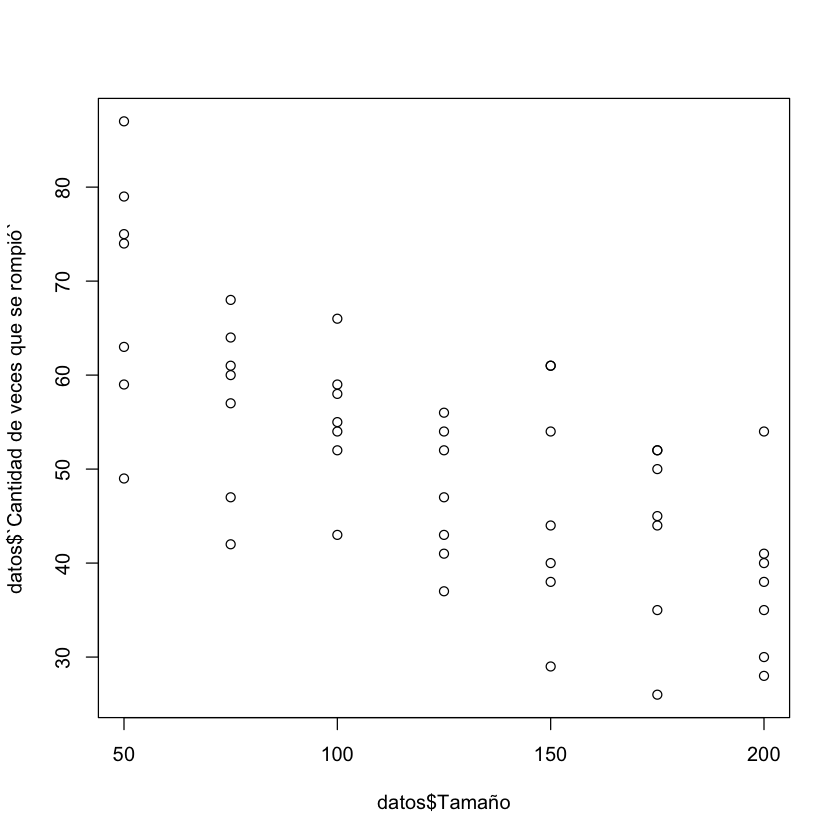

In [319]:
plot(x=datos$`Tamaño`, y=datos$`Cantidad de veces que se rompió`)